In [ ]:
pip install symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 125 kB 46.5 MB/s 


In [ ]:
pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 5.3 MB/s 
     |████████████████████████████████| 965 kB 64.3 MB/s 


In [ ]:
import json
import pandas as pd
import re
from pyvi import ViTokenizer
import pkg_resources
from symspellpy import SymSpell, Verbosity
import itertools
import h5py

from PIL import Image, ImageOps
import requests
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch import einsum

from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Analysis

In [ ]:
dicts = json.load(open('/content/drive/MyDrive/UIT-ViIC/uitviic_captions_train2017.json'))
images = pd.json_normalize(dicts['images'])
annotations = pd.json_normalize(dicts['annotations'])
data = images.merge(annotations, left_on ='id', right_on = 'image_id')
data

license         file_name  \
0            2  000000535668.jpg   
1            2  000000535668.jpg   
2            2  000000535668.jpg   
3            2  000000535668.jpg   
4            2  000000535668.jpg   
...        ...               ...   
13476        1  000000574455.jpg   
13477        1  000000574455.jpg   
13478        1  000000574455.jpg   
13479        1  000000574455.jpg   
13480        1  000000574455.jpg   

                                                coco_url  height  width  \
0      http://images.cocodataset.org/train2017/000000...     426    640   
1      http://images.cocodataset.org/train2017/000000...     426    640   
2      http://images.cocodataset.org/train2017/000000...     426    640   
3      http://images.cocodataset.org/train2017/000000...     426    640   
4      http://images.cocodataset.org/train2017/000000...     426    640   
...                                                  ...     ...    ...   
13476  http://images.cocodataset.org/train2017/000000...     640    427   
13477  http://images.cocodataset.org/train2017/000000...     640    427   
13478  http://images.cocodataset.org/train2017/000000...     640    427   
13479  http://images.cocodataset.org/train2017/000000...     640    427   
13480  http://images.cocodataset.org/train2017/000000...     640    427   

             date_captured                                         flickr_url  \
0      2013-11-19 18:06:56  http://farm4.staticflickr.com/3061/2442277392_...   
1      2013-11-19 18:06:56  http://farm4.staticflickr.com/3061/2442277392_...   
2      2013-11-19 18:06:56  http://farm4.staticflickr.com/3061/2442277392_...   
3      2013-11-19 18:06:56  http://farm4.staticflickr.com/3061/2442277392_...   
4      2013-11-19 18:06:56  http://farm4.staticflickr.com/3061/2442277392_...   
...                    ...                                                ...   
13476  2013-11-20 19:52:16  http://farm9.staticflickr.com/8115/8660218215_...   
13477  2013-11-20 19:52:16  http://farm9.staticflickr.com/8115/8660218215_...   
13478  2013-11-20 19:52:16  http://farm9.staticflickr.com/8115/8660218215_...   
13479  2013-11-20 19:52:16  http://farm9.staticflickr.com/8115/8660218215_...   
13480  2013-11-20 19:52:16  http://farm9.staticflickr.com/8115/8660218215_...   

         id_x  image_id                                            caption  \
0      535668    535668  Cầu thủ bóng chày đang bước tới đỡ bóng trong ...   
1      535668    535668  Cầu thủ bóng chày đang cầm gậy thi đấu trên sân .   
2      535668    535668       Người đàn ông đang chơi bóng chày trên sân .   
3      535668    535668  Cầu thủ bóng chày đang vung gậy bóng chày đỡ b...   
4      535668    535668  Cầu thủ bóng chày đang vung gậy đánh trả bóng ...   
...       ...       ...                                                ...   
13476  574455    574455   Một người đàn ông đang đứng ở trên sân bóng đá .   
13477  574455    574455  Một người đàn ông đang giơ tay lên cao ở trên ...   
13478  574455    574455  Một ông già đang giơ tay lên cao ở trên sân bó...   
13479  574455    574455  Một nam thủ môn đang giơ tay lên cao ở trên sân .   
13480  574455    574455  Một nam thủ môn đang đứng ở trước quả bóng ở t...   

        id_y  
0       2237  
1      17770  
2      14876  
3      11817  
4       8018  
...      ...  
13476  15946  
13477   3228  
13478    347  
13479   1319  
13480   4095  

[13481 rows x 11 columns]

In [ ]:
!pip3 install py_vncorenlp
import py_vncorenlp
py_vncorenlp.download_model(save_dir='/content/drive/MyDrive')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.5 MB/s 
  Created wheel for py-vncorenlp: filename=py_vncorenlp-0.1.3-py3-none-any.whl size=4309 sha256=8b2b20e10f11e31ffd4e508e11b99cd212b61cc8b9f4b919df52df99237661f4
  Stored in directory: /root/.cache/pip/wheels/87/be/55/d5930c1d90a09832e9afd57a9e13801e3d16c88f5a19f777ae
Successfully built py-vncorenlp
The VnCoreNLP model is already!


In [ ]:
captions = data['caption'].copy()
captions_segment = data['caption'].copy()

### Add new word for a vocabulary

In [ ]:
def add_vocab(vocab,captions, max_length):
 # 'thêm từ cho từ điển'
  for caption in captions:
    words = caption.split()
    max_length = len(words) if (max_length < len(words)) else max_length
    for word in words:
      if word in vocab.keys():
        vocab[word] += 1
      else:
        vocab[word] = 1

### Word count

Number of word in each caption

In [ ]:
syllable_level_vocab = {}
word_level_vocab = {}
for i in range(len(captions)):
  captions[i] = str(captions[i]).lower()
  captions[i] = re.sub(r'[!@#$%^&*(){}?\\.//]', '', captions[i])
  captions_segment[i] = captions_segment[i].lower()
  captions_segment[i] = re.sub(r'[!@#$%^&*(){}?\\.//]', '', captions_segment[i])
  captions_segment[i] = "".join(rdrsegmenter.word_segment(captions_segment[i]))
add_vocab(word_level_vocab, captions_segment,0)
add_vocab(syllable_level_vocab, captions,0)

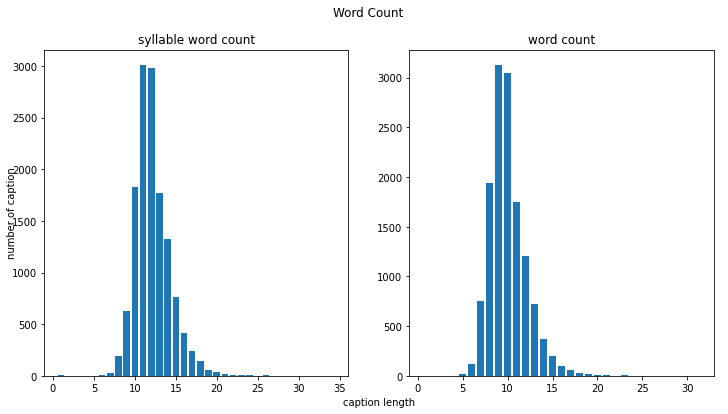

In [ ]:
syllable_word_count = {}
for i in captions:
  if len(i.strip().split()) not in syllable_word_count.keys():
    syllable_word_count[len(i.strip().split())] = 1
  else:
    syllable_word_count[len(i.strip().split())] += 1
word_level_count = {}
for i in captions_segment:
  if len(i.strip().split()) not in word_level_count.keys():
    word_level_count[len(i.strip().split())] = 1
  else:
    word_level_count[len(i.strip().split())] += 1


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
fig.suptitle('Word Count')
ax1.bar(list(syllable_word_count.keys()), list(syllable_word_count.values()))
ax2.bar(list(word_level_count.keys()), list(word_level_count.values()))
ax.set_xlabel('caption length')
ax.set_ylabel('number of caption')
ax1.set_title('syllable word count')
ax2.set_title('word count')
plt.show() 

#II, Data Preprocessing


#II.1 Image Processing

In [ ]:
def resize_with_padding(img, expected_size):
  img.thumbnail((expected_size[0], expected_size[1]))
  delta_width = expected_size[0] - img.size[0]
  delta_height = expected_size[1] - img.size[1]
  pad_width = delta_width // 2
  pad_height = delta_height // 2
  padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
  return ImageOps.expand(img, padding)

In [ ]:
def image_preprocessing(img, size):
  'xử lý ảnh: bao gồm resize lại ảnh và normalize lại ảnh'
  image = resize_with_padding(img, size)
  transform = transforms.ToTensor()
  mean, std = transform(image).mean([1,2]), transform(image).std([1,2])
  transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])
  img_normalized = transform_norm(image)
  return img_normalized

#II.2 Caption Processing

In [ ]:
#get a file contains all vietnamese single words
f = open('/content/drive/MyDrive/VietnameseWords.txt', encoding="utf-8")
vietnamese_words = []
for line in f:
  for word in line.split(" "):
    word = re.sub(r'\n', '', word)
    if word not in vietnamese_words:
      vietnamese_words.append(word)



Check if any caption contains numbers rather than pure text

In [ ]:
for caption in data['caption']:
  for word in caption.split(' '):
    if word.isnumeric():
      print(caption)


Một cầu thủ số 11 đang theo dõi cú đánh bóng của cầu thủ đánh bóng .
Cậu bé mặc áo số 3 đang cầm gậy đánh bóng chày .
Hình ảnh con hải cẩu đang chơi với 2 quả bóng phao trên mặt nước.
Cầu thủ số 53 đang chuẩn bị ném quả bóng chày .
Cầu thủ bóng chày áo số 27 đang cầm gậy đánh bóng .
Vận động viên tennis nữ đang cầm vợt thi đấu trên sân phút thứ 6 .
Một cầu thủ bóng chày áo số 24 đang vung gậy đánh trả bóng trong trận .
Nữ cầu thủ số 18 đang chạy để tranh chấp bóng với nữ cầu thủ áo trắng cam .
Cầu thủ bóng chày mang áo số 10 đang ném bóng .
Cầu thủ số 18 đang dùng chân trái để sút bóng ở trên sân .
Cầu thủ số 18 đang dùng chân để sút quả bóng ở trên sân .
Phía sau cô bé là con đường cắt ngang . 1
Cầu thủ bóng chày áo số 9 đang cầm gậy thi đấu trên sân .
Các nữ cầu thủ khác đang theo dõi chuyển động của nữ cầu thủ số 6 .
Cầu thủ bóng chày áo số 18 đang cầm gậy đỡ bóng thấp .
Cầu thủ số 13 đang dắt bóng và di chuyển cạnh trọng tài .
Cầu thủ số 13 đang dẫn bóng bằng chân phải .
Khán giả đ

Since there are a lot of captions that contain numbers, and our Vietnamese dictionary does not contain numbers. So rather than remove all those number, we turn all of those numbers into text.
For example: 15 => 'mười lăm'

In [ ]:
class NumToVnStr:
    def __init__(self, mươi='mươi', nghìn='nghìn', tư='tư', lăm='lăm', linh='linh', tỷ='tỷ', đọc_số_rỗng=True):
        self.chữ_số = ('không', 'một', 'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười')
        self.mươi = mươi
        self.trăm = 'trăm'
        self.nghìn = nghìn
        self.triệu = 'triệu'
        self.tỷ = tỷ
        self.mốt = 'mốt'
        self.tư = tư
        self.lăm = lăm
        self.linh = linh
        self.đọc_số_rỗng = đọc_số_rỗng
    def to_vn_str(self, s):
        return self._arbitrary(s.lstrip('0'))
    def _int(self, c):
        return ord(c) - ord('0') if c else 0
    def _LT1e2(self, s):
        if len(s) <= 1: return self.chữ_số[self._int(s)]
        if s[0] == '1':
            ret = self.chữ_số[10]
        else:
            ret = self.chữ_số[self._int(s[0])]
            if self.mươi: ret += ' ' + self.mươi
            elif s[1] == '0': ret += ' mươi'
        if s[1] != '0':
            ret += ' '
            if   s[1] == '1' and s[0] != '1': ret += self.mốt
            elif s[1] == '4' and s[0] != '1': ret += self.tư
            elif s[1] == '5': ret += self.lăm
            else: ret += self.chữ_số[self._int(s[1])]
        return ret
    def _LT1e3(self, s):
        if len(s) <= 2: return self._LT1e2(s)
        if s == '000': return ''
        ret = self.chữ_số[self._int(s[0])] + ' ' + self.trăm
        if s[1] != '0':
            ret += ' ' + self._LT1e2(s[1:])
        elif s[2] != '0':
            ret += ' ' + self.linh + ' ' + self.chữ_số[self._int(s[2])]
        return ret
    def _LT1e9(self, s):
        if len(s) <= 3: return self._LT1e3(s)
        if s == '000000' or s == '000000000': return ''
        mid = len(s) % 3 if len(s) % 3 else 3
        left, right = self._LT1e3(s[:mid]), self._LT1e9(s[mid:])
        hang = self.nghìn if len(s) <= 6 else self.triệu
        if not left:
            if not self.đọc_số_rỗng: return right
            else: return self.chữ_số[0] + ' ' + hang + ' ' + right
        if not right: return left + ' ' + hang
        return left + ' ' + hang + ' ' + right
    def _arbitrary(self, s):
        if len(s) <= 9: return self._LT1e9(s)
        mid = len(s) % 9 if len(s) % 9 else 9
        left, right = self._LT1e9(s[:mid]), self._arbitrary(s[mid:])
        hang = ' '.join([self.tỷ] * ((len(s) - mid) // 9))
        if not left:
            if not self.đọc_số_rỗng: return right
            elif right: return self.chữ_số[0] + ' ' + hang + ', ' + right
            else: return right
        if not right: return left + ' ' + hang
        return left + ' ' + hang + ', ' + right

custom_converter = NumToVnStr(đọc_số_rỗng=True, linh='lẻ', tư='bốn', nghìn='ngàn', mươi=False, tỷ='tỉ', lăm='nhăm')
print(custom_converter.to_vn_str('12'))

mười hai


In [ ]:
def replace_num_by_text(caption):
  for word in caption.split():
    if word.isnumeric():
      new_word = NumToVnStr(đọc_số_rỗng=True, linh='lẻ', tư='bốn', nghìn='ngàn', mươi=False, tỷ='tỉ', lăm='nhăm').to_vn_str(word)
      caption = re.sub(word, new_word, caption)
  return caption

In [ ]:
print(replace_num_by_text('có 150 con bò'))

có một trăm năm mươi con bò


We build a model to handle misplelled word, so that our model can learn better

In [ ]:

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary('/content/drive/MyDrive/vietnamese-dictionary.txt', term_index=0, count_index=1)
def recorrect_word(input_term):
# max edit distance per lookup (per single word, not per whole input string)

  suggestions = sym_spell.lookup(input_term, Verbosity.TOP, max_edit_distance=2,include_unknown=True)
# display suggestion term, edit distance, and term frequency
  for suggestion in suggestions:
    return str(str(suggestion).split(",")[0])
print(recorrect_word('chelsea'))

chelsea


Some mispelled word are unikey-error, and there's no library or logical method that can help us recorrect these word, thus this kind of error doesn't occur often, so we can handle them directly

In [ ]:
correct_dict = {'chwoi': 'chơi', 'cvhujp':'chụp', 'xusc':' xúc', 'đfan':'đàn','ddeo':'đeo', 'bosnbg' : 'bóng', 'bogn':'bóng', 'nma': 'nam', 'cvhafy':'chày', 'nhwunxg':'những', 'nhwuxng':'những', 'vbowjt':'vợt', 'hadng': 'hàng','caaju':'cậu' , 'phsia':'phía' , 'pụ':'phụ', 'gaajy':'gậy', 'vopwjt':'vợt', 'nguwofi':'người', 'vnaja':'vận', 'towdi':'tới' }
def mispell_handling(caption):
  for word in caption.split(" "):
    if word not in vietnamese_words:
      if word in correct_dict.keys():
        caption = re.sub(word, correct_dict[word], caption)  
      else:
        correct_word = recorrect_word(word)
        #print(word, ' --> ', correct_word )
        caption = re.sub(word, correct_word, caption)
  return caption
    


In [ ]:
def caption_preprocessing(caption):
  #preprocess caption: bao gồm xóa ký tự đặc biệt, xóa padding hai đầu và thêm <sos> +< eos> và sửa lỗi chính tả
  caption = re.sub(r'[!@#$%^&*(){}?\\].,', '', caption)
  caption = replace_num_by_text(caption) #thay các số bằng cách đọc tiếng việt
  caption= caption.strip().split()
  caption = [word for word in caption if word.isalpha()]
  caption = " ".join([tok.lower() for tok in caption])
  caption = mispell_handling(caption)
  caption = " ".join([tok for tok in ViTokenizer.tokenize(caption).split(' ')])
  caption =  '<sos> '+ caption+ ' <eos>'
  return caption

An example of how we fix our caption for a better learning

In [ ]:
print(caption_preprocessing("hômn nay là 1 ngày đẹpp trờii  "))

<sos> hôm_nay là một ngày đẹp trời <eos>


Check if there is any mispelled word in our caption in the trainset


In [ ]:
for caption in data['caption']:  
  caption = caption_preprocessing(caption)
  for word in caption.split(" "):
    if word not in vietnamese_words:
      print(word)

hính
trến
sânl
nguời
nguời
chwoi
chwoi
đangt
bosnbg
chwoi
chwoi
namd
chwoi
nma
đánn
caon
đượt
nguời
nguời
đâng
trới
chuản
ỏ
đấ
bóngc
đanng
tổi
chwoi
thoe
cuớp
cuớp
cvhafy
bươc
chwoi
treen
nguời
trến
nhwuxng
đứn
nguời
dất
hadng
trến
caaju
tenní
teay
chươi
phsia
short
dodng
độngt
đứbg
bogn
pụ
đánht
nhực
đấ
nguời
hiệ
đng
ddeo
trến
nogafi
trến
vest
áu
ngưỡi
đfan
đấn
tennnis
trến
đựa
tenis
đnag
đnag
chươi
tenns
tenns
tenns
qurng
tennnis
tenní
tenins
gải
indians
red
sox
indians
red
sox
indians
red
sox
swing
môt
tenins
tenins
sânn
chắng
đắu
bj
xusc
tennnis
gaajy
cola
noài
viêng
vopwjt
chajky
tenis
nữu
nữu
tenní
halloween
nguời
huỵnh
chwoi
trến
luyệ
đng
ndma
bosnbg
thut
thut
gbay
nguwofi
towdi
phsia
nguwofi
môt
môt
chajy
qủa
ônng
coke
cola
đứung
tbosng
bsong
nguời
chuản
môt
môt
bém
môt
phụi
phụi
nguời
gòi
sâ
tenis
nguwofi
vậnd
short
cvhujp
trến
pụ
ảu
đsng
môt
ng
vbowjt
vìa
tennsi
trến
chươi
nguwofi
vnaja
vnaja
vnaja
tenní
só
đứung
thủe
trennis
tren
thựa
tenins
bẳt
chwoi
chuần
tthi
ậy
boo
boo
t

In [ ]:
#caption preprocessing test
print(caption_preprocessing("Đi chwoi thôt các bạn"))

<sos> đi chơi thôi các bạn <eos>


In [ ]:
def add_vocab(vocab,captions, max_length):
 # 'thêm từ cho từ điển'
  for caption in captions:
    words = caption.split()
    max_length = len(words) if (max_length < len(words)) else max_length
    for word in words:
      if word in vocab.keys():
        vocab[word] += 1
      else:
        vocab[word] = 1

# Data Augmentation

In [ ]:
import torchvision.transforms as T
import torch
import numpy as np
import cv2
from PIL import Image
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        ToTensorV2(),
    ]
)

In [ ]:
def plot_image(image):
    transform = T.ToPILImage()
    image = transform(image)
    plt.figure(figsize=(7, 7))
    plt.imshow(image)


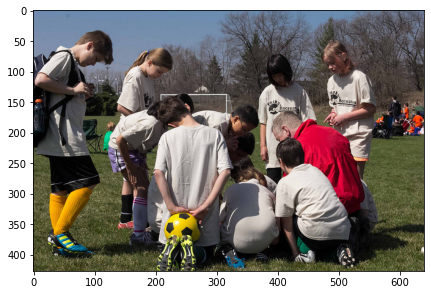

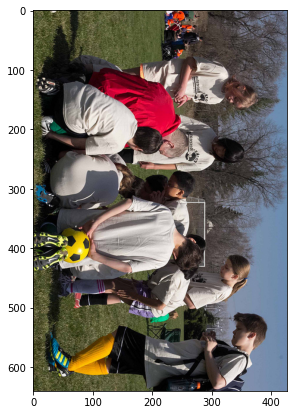

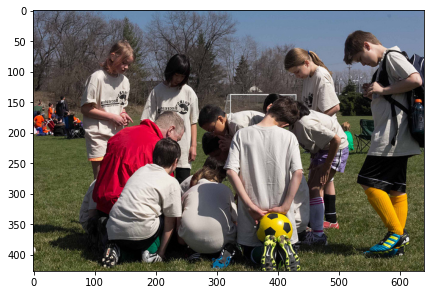

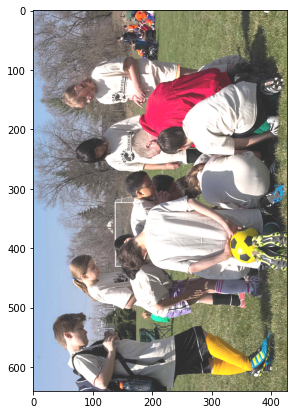

In [ ]:
image = Image.open(requests.get('http://images.cocodataset.org/train2017/000000541010.jpg', stream=True).raw).convert('RGB')
plt.figure(figsize=(7, 7))
plt.imshow(image)
image = np.array(image)

transformed_image_1 = transform(image=image)['image']
transformed_image_2 = transform(image=image)['image']
transformed_image_3 = transform(image=image)['image']
plot_image(transformed_image_1)
plot_image(transformed_image_2)
plot_image(transformed_image_3)

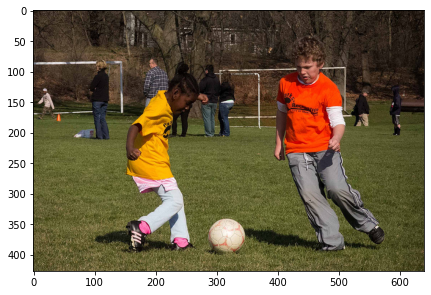

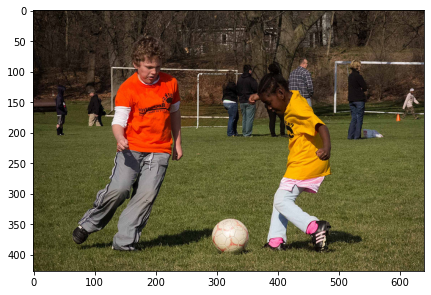

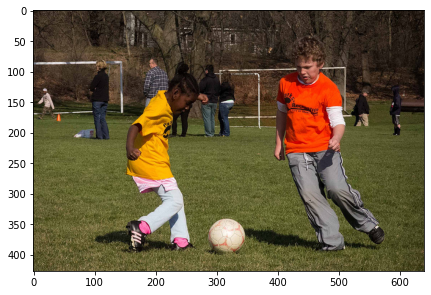

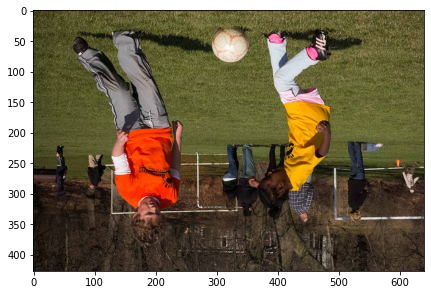

In [ ]:
image = Image.open(requests.get('http://images.cocodataset.org/train2017/000000289444.jpg', stream=True).raw).convert('RGB')
plt.figure(figsize=(7, 7))
plt.imshow(image)
image = np.array(image)

transformed_image_1 = transform(image=image)['image']
transformed_image_2 = transform(image=image)['image']
transformed_image_3 = transform(image=image)['image']
plot_image(transformed_image_1)
plot_image(transformed_image_2)
plot_image(transformed_image_3)

# Vocab

In [ ]:
vocab = {}
add_vocab(vocab, [caption_preprocessing(caption) for caption in data['caption']],0)
vocab['<unk>'] = 0


In [ ]:
print(dict(itertools.islice(vocab.items(), 5)))

{'<sos>': 13481, 'cầu_thủ': 3105, 'bóng_chày': 3234, 'đang': 12459, 'bước': 230}


In [ ]:
word_to_idx = {}
idx_to_word = []
words_and_frequencies = sorted(vocab.items(), key=lambda tup: tup[0])
words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

for word, freq in words_and_frequencies:
  idx_to_word.append(word)
word_to_idx.update({token: i for i, token in enumerate(idx_to_word)})

print(len(word_to_idx))

1192


# Embedding

A pretrained weight for embedding layer from PhoW2V

In [ ]:
def is_float(string) -> bool:
    try:
        float(string)
        return True
    except ValueError:
        return False

In [ ]:
embeddings_index = {} # empty dictionary
counter = 0
file = open('/content/drive/MyDrive/word2vec_vi_words_300dims.txt', encoding="utf-8")
for line in file:
  values = line.split()
  word = values[0]
  if word in word_to_idx.keys():
    if is_float(values[1]):
      coefs = np.asarray(values[1:], dtype='float32')
    elif is_float(values[2]):
      coefs = np.asarray(values[2:], dtype='float32')
    else:
      coefs = np.asarray(values[3:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1145 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = len(vocab)
embedding_matrix = torch.Tensor(vocab_size, embedding_dim)

for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in the embedding index will be all zeros
      embedding_matrix[i] = torch.tensor(embedding_vector, )
    else: 
      if word == '<sos>': 
        embedding_matrix[i] = torch.ones(embedding_dim)*1
      elif word == '<eos>':
        embedding_matrix[i] = torch.ones(embedding_dim)*(-1)
      else:
        embedding_matrix[i] = torch.ones(embedding_dim)*3
print(embedding_matrix.shape)


torch.Size([1192, 300])


#III, BUILDING A MODEL

# Dataset


In [ ]:
import torchvision.transforms as T
from PIL import Image

In [ ]:
from torchvision.io import read_image

class ICDataset(Dataset):
    def __init__(self, hdf5_dir, json_dir,embedding_matrix, word_to_idx, transform = None ):
      dicts = json.load(open(json_dir))
      images = pd.json_normalize(dicts['images'])
      annotations = pd.json_normalize(dicts['annotations'])
      images['file_name'] =  [i for i in h5py.File(hdf5_dir, "r+")["/images"]]
      data = images.merge(annotations, left_on ='id', right_on = 'image_id')
      self.img_caption = [caption_preprocessing(data['caption'][i]) for i in range(len(data['caption']))]
      self.img_dir = data['file_name'] 
      self.embedding_matrix = embedding_matrix
      self.word_to_idx = word_to_idx
      self.maxlength_cap =  max([len(cap.split()) for cap in self.img_caption])
      self.image_id = data['image_id']    
      self.transform = transform    

    def __len__(self):
        return len(self.img_caption)

    def __getitem__(self, idx):
        image = Image.fromarray(self.img_dir[idx])
        
        # if image.size() != torch.Size([3, 224, 224]):
        #         print(image.size()) 
        embed_caption = []
        for word in self.img_caption[idx].split():
          embed_caption.append(torch.LongTensor([self.word_to_idx.get(word, self.word_to_idx['<unk>'])]))
        for i in range(self.maxlength_cap+1-len(self.img_caption[idx].split())):
          embed_caption.append(torch.zeros(1).long())
        encoded_caption = torch.stack(embed_caption).flatten()
        encoded_caplens = torch.tensor(len(self.img_caption[idx].split()),dtype=torch.int8).unsqueeze(0)
        if self.transform is not None:
            image = np.array(image)
            augmentations = self.transform(image=image)
            image = augmentations["image"] 
            transforms = T.ToPILImage()
            image = transforms(image)
            #image = image_preprocessing(image, (224,224))
        image = image_preprocessing(image, (224,224))
        return image,self.img_caption[idx] ,encoded_caption, encoded_caplens,self.image_id[idx]


#Data Loader

In [ ]:
train_data =  ICDataset('/content/drive/MyDrive/train_images.h5','/content/drive/MyDrive/UIT-ViIC/uitviic_captions_train2017.json',embedding_matrix, word_to_idx, transform=transform)
test_data =   ICDataset('/content/drive/MyDrive/test_images.h5','/content/drive/MyDrive/UIT-ViIC/uitviic_captions_test2017.json',embedding_matrix, word_to_idx,transform=None)
val_data =   ICDataset('/content/drive/MyDrive/val_images.h5','/content/drive/MyDrive/UIT-ViIC/uitviic_captions_val2017.json',embedding_matrix, word_to_idx,transform= None)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

train_image, train_caption, train_end_cap, train_cap_len, train_image_id = next(iter(train_dataloader))

In [ ]:
type(test_dataloader)

torch.utils.data.dataloader.DataLoader

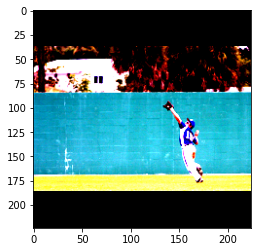

Caption: <sos> một người đàn_ông đang xoay người để đánh_quả bóng_chày <eos>


In [ ]:
n =56
img1 = train_image[2]
for img in train_image:
  if img.size() != torch.Size([3, 224, 224]):
    print(img.size())
# print(img1.size())
caption = train_caption[n]
# print(train_cap_len.size())
# print(train_end_cap.size())
plt.imshow(img1.permute(1, 2, 0))
plt.show()
print(f"Caption: {caption}")

# Architecture 
Encoder: Image Dataset -> CNN -> Feature vector

Caption -> Word Embeding Vector 

Encoder + Word Embedding Vector -> Decoder (LSTM +Attention) 
                                        

## Encoder

Use resnet-152 to extract feature map

In [ ]:
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet152(weights ='ResNet152_Weights.DEFAULT') 

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        for p in self.resnet.parameters():
          p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
          for p in c.parameters():
            p.requires_grad = True

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out


## Attention 

Attention to the important pixel from the encoder 

In [ ]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding,  alpha

## Decoder with Attention

Use LSTM combine with Attention

In [ ]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embeddings, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embeddings: embedding matrix
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        for p in self.embedding.parameters():
            p.requires_grad = False
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.embedding.load_state_dict({'weight': embeddings})

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h,c =  self.init_hidden_state(encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind



# Model

Put all thing together and generate caption through beam search

In [ ]:
class ICModel(nn.Module):
  def __init__(self,attention_dim,embeddings, emb_dim,decoder_dim,vocab,dropout, word_to_idx):
    super(ICModel, self).__init__()
    self.word_to_idx = word_to_idx
    self.vocab = vocab
    self.encoder = Encoder()
    self.decoder = DecoderWithAttention(attention_dim=attention_dim,
                                        embeddings = embeddings,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(vocab),
                                       dropout=dropout)
  def forward(self,imgs,caps, caplens):
    imgs = self.encoder(imgs)
    scores, caps_sorted, decode_lengths, alphas, sort_ind = self.decoder(imgs, caps, caplens)
    return scores, caps_sorted, decode_lengths, alphas, sort_ind
  def predict(self, preprocessed_image, beam_size):
    k= beam_size
    vocab_size = len(self.vocab)
    image = preprocessed_image.unsqueeze(0)
    encoder_out = self.encoder(image) 
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_to_idx['<sos>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Lists to store completed sequences and scores
    complete_seqs = list()
    complete_seqs_scores = list()
    # Start decoding
    step = 1
    h, c = self.decoder.init_hidden_state(encoder_out)
    alphas = []


    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = self.decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = self.decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
        alphas.append(alpha.cpu().detach().numpy())


        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = self.decoder.sigmoid(self.decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = self.decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = self.decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != self.word_to_idx['<eos>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]

    return seq, alphas

    

In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
# torch.save(model.state_dict(),'/content/drive/MyDrive/model1.pt')

#Train

In [ ]:
# emb_dim = 300  # dimension of word embeddings
# attention_dim = 512  # dimension of attention linear layers
# decoder_dim = 512  # dimension of decoder RNN
# dropout = 0.5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
# # Training parameters
# start_epoch = 0
# epochs = 10  # number of epochs to train for (if early stopping is not triggered)
# lr = 2e-4  # learning rate for encoder if fine-tuning
# grad_clip = 5.  # clip gradients at an absolute value of
# alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper


# model =ICModel(attention_dim=attention_dim,
#                embeddings = embedding_matrix,
#                emb_dim=emb_dim,
#                decoder_dim=decoder_dim,
#                vocab=vocab,
#                dropout=dropout,
#                word_to_idx = word_to_idx)
# optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
#                                     lr=lr)

# # Move to GPU, if available
# model = model.to(device)

# # Loss function
# criterion = nn.CrossEntropyLoss().to(device)

# for epoch in range(start_epoch, epochs):

#   for i, (imgs, caption , caps, caplens, image_id) in enumerate(train_dataloader):
#         # Move to GPU, if available
#         imgs = imgs.to(device)
#         caps = caps.to(device)
#         caplens = caplens.to(device)

#         # Forward prop.
#         scores, caps_sorted, decode_lengths, alphas, sort_ind = model(imgs, caps, caplens)

#         # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
#         targets = caps_sorted[:, 1:]

#         # Remove timesteps that we didn't decode at, or are pads
#         # pack_padded_sequence is an easy trick to do this
#         scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
#         targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

#         # Calculate loss
#         loss = criterion(scores.data, targets.data)
#         # Add doubly stochastic attention regularization
#         loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

#         # Back prop.
#         optimizer.zero_grad()
#         loss.backward()

#         # Clip gradients
#         if grad_clip is not None:
#             clip_gradient(optimizer, grad_clip)

#         # Update weights
#         optimizer.step()
#   torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, '/content/drive/MyDrive/checkpoint.pt')

# Evaluation

In [ ]:
emb_dim = 300  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
# Training parameters
start_epoch = 0
epochs = 10  # number of epochs to train for (if early stopping is not triggered)
lr = 2e-4  # learning rate for encoder if fine-tuning
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
model =ICModel(attention_dim=attention_dim,
               embeddings = embedding_matrix,
               emb_dim=emb_dim,
               decoder_dim=decoder_dim,
               vocab=vocab,
               dropout=dropout,
               word_to_idx = word_to_idx)



Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model1.pt',map_location = torch.device('cpu')), strict = False)
model.to(device)

ICModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (

<sos> một người đàn_ông đang chơi tennis ở trên sân <eos> 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


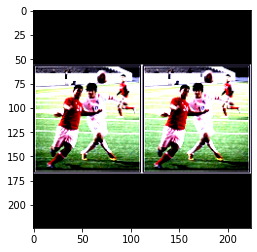

In [ ]:
n= 17
test_image, test_caption, test_end_cap, test_cap_len, test_image_id = next(iter(test_dataloader))
plt.imshow(test_image[n].permute(1,2,0))
caption_idx , alphas= model.predict(test_image[n].to(device),5)

caption_predict = ''
for i in caption_idx:
  caption_predict += idx_to_word[i]+ ' '
print(caption_predict)


# IV, RESULT

We test our model on test set

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
model.eval()

test_image, test_caption, test_end_cap, test_cap_len, test_image_id = next(iter(test_dataloader))
list_predict, score_test, index =[], [], []
for i in range(len(test_caption)):
  index.append(i)
  caption_idx = model.predict(test_image[i].to(device),5)
  caption_predict = ' '.join([idx_to_word[i] for i in caption_idx])
  list_predict.append(caption_predict)
  score_test.append(corpus_bleu([[test_caption[i]]], [caption_predict],weights=(0, 0, 0, 1)))
print('Train bleu_score_4: ', sum(score_test)/len(score_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Test bleu_score_4:  0.41516702661401633


We do the same on our training set

In [ ]:
train_image, train_caption, train_end_cap, train_cap_len, train_image_id = next(iter(train_dataloader))
score_train = []
for i in range(len(train_caption)):
  caption_idx = model.predict(train_image[i].to(device),5)
  caption_predict = ' '.join([idx_to_word[i] for i in caption_idx])
  score_train.append(corpus_bleu([[train_caption[i]]], [caption_predict], weights=(0, 0, 0, 1)))
print('Train blue score 4: ', sum(score_train)/len(score_train))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Train blue score 4:  0.49231049683179234


#V, Error Analyses

We check some caption in our test set and how our model predict 

In [ ]:
' '.join(test_references[1][0])
for i in range(5,10):
  print('Correct: ',' '.join(test_references[i][0]),' | Predict: ', ' '.join(test_hypotheses[i]))

Correct:  <sos> một người đàn_ông đang vung gậy để đánh_quả bóng_chày <eos>  | Predict:  <sos> một người đàn_ông đang chơi bóng_đá ở trên sân <eos>
Correct:  <sos> người phụ_nữ áo xám đang tung quả bóng lên cao để phát_bóng ở trên sân tennis <eos>  | Predict:  <sos> một người đàn_ông đang chơi bóng_đá ở trên sân <eos>
Correct:  <sos> một cậu bé đang cầm gậy bóng_chày và một cậu bé ngồi trên xe_đạp <eos>  | Predict:  <sos> một người đàn_ông đang chơi bóng_đá ở trên sân <eos>
Correct:  <sos> một cậu bé đang giơ vợt lên cao ở trên sân tennis <eos>  | Predict:  <sos> một người đàn_ông đang chơi bóng_đá ở trên sân <eos>
Correct:  <sos> hai vận_động_viên tennis nữ đang cầm vợt thi_đấu trên sân <eos>  | Predict:  <sos> một người đàn_ông đang chơi bóng_đá ở trên sân <eos>


In [ ]:
#sort the vocab list in term of frequency
vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1], reverse=True)}
#list of 20 most common word
dict_items = vocab.items()
common_words =  list(dict_items)[2:42]
print(common_words)

[('đang', 12459), ('tennis', 6575), ('người', 6120), ('bóng', 5674), ('trên', 5601), ('một', 5556), ('sân', 4813), ('bóng_chày', 3234), ('vợt', 3205), ('đàn_ông', 3163), ('cầu_thủ', 3105), ('ở', 2923), ('vận_động_viên', 2850), ('cầm', 2522), ('để', 2252), ('đánh_bóng', 2218), ('chơi', 2101), ('quả', 1637), ('nam', 1483), ('phụ_nữ', 1479), ('thi_đấu', 1444), ('chuẩn_bị', 1419), ('áo', 1409), ('đứng', 1358), ('ném', 1258), ('nữ', 1183), ('gậy', 1154), ('và', 1125), ('những', 1110), ('đánh_quả', 1069), ('hai', 1052), ('bé', 1049), ('vung', 1039), ('lên', 975), ('bóng_đá', 968), ('trẻ', 961), ('trong', 886), ('của', 861), ('đứa', 841), ('đỡ', 779)]


Text(0, 0.5, 'frequency')

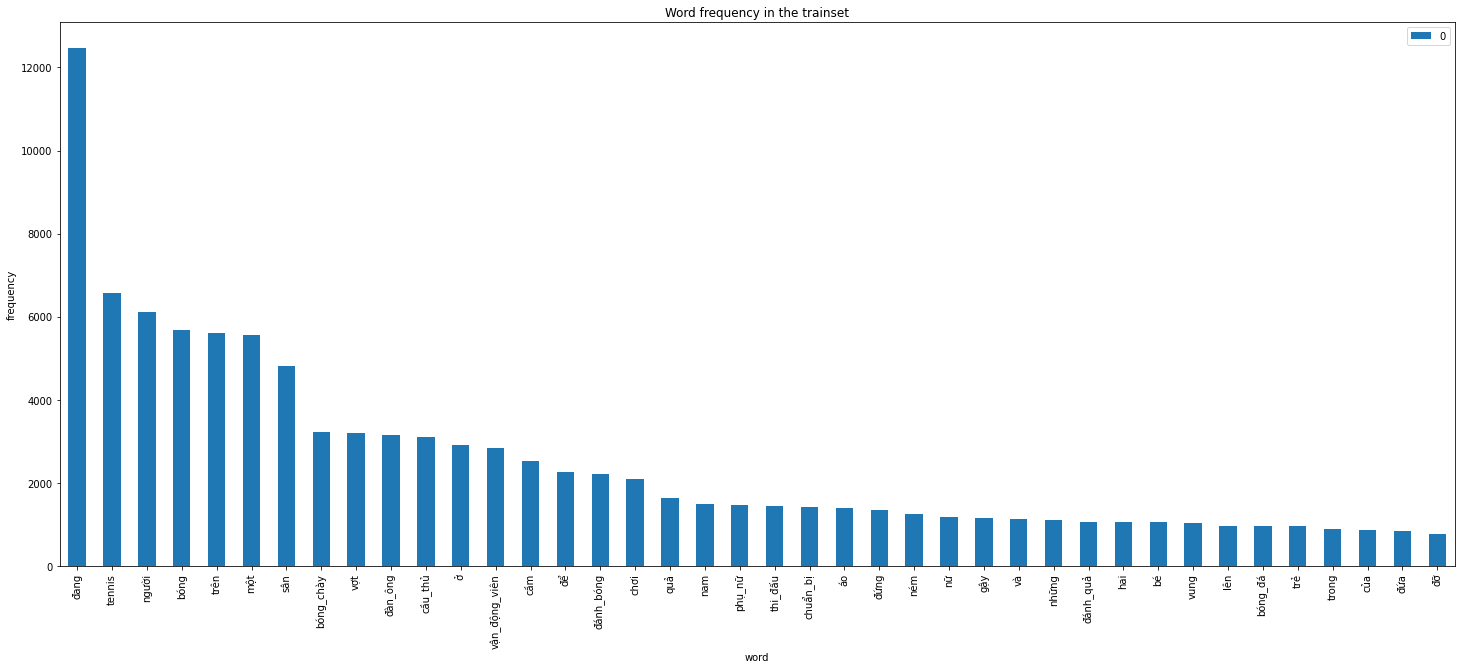

In [ ]:
words = [i[0] for i in common_words]
frequency = [i[1] for i in common_words]
plotdata = pd.DataFrame(
    frequency, 
    index=words)
# Plot a bar chart
plotdata.plot(kind="bar",figsize=(25,10))
plt.title('Word frequency in the trainset')
plt.xlabel('word')
plt.ylabel('frequency')

Above chart is a chart that shows the most 20 common word used in the trainset, from that we obtain a great bias from captions that prone to describe any action that related to ''baseball','tennis','sport',... 

In [ ]:
dict = json.load(open('/content/drive/MyDrive/UIT-ViIC/uitviic_captions_test2017.json'))
images = pd.json_normalize(dict['images'])
annotations = pd.json_normalize(dict['annotations'])
test_data = images.merge(annotations, left_on ='id', right_on = 'image_id')
test_data.shape

(1155, 11)

In [ ]:
test_image, test_caption, test_end_cap, test_cap_len, test_image_id = next(iter(test_dataloader))

In [ ]:
# n =56
# img1 = train_image[n]
# for img in train_image:
#   if img.size() != torch.Size([3, 224, 224]):
#     print(img.size())
# # print(img1.size())
# caption = train_caption[n]
# # print(train_cap_len.size())
# # print(train_end_cap.size())
# plt.imshow(img1.permute(1, 2, 0))
# plt.show()
# print(f"Caption: {caption}")

In [ ]:
len(test_caption)

256

In [ ]:
list_predict, score, index =[], [], []
for i in range(len(test_caption)):
  index.append(i)
  caption_idx, alphas = model.predict(test_image[i].to(device),5)
  caption_predict = ' '.join([idx_to_word[i] for i in caption_idx])
  list_predict.append(caption_predict)
  score.append(corpus_bleu([[test_caption[i]]], [caption_predict]))
df = pd.DataFrame(list(zip(index, test_image, test_caption, list_predict, score)),
               columns =['Index','Image', 'Correct', 'Predict', 'Bleu Score'])

  
  

  
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


We have a look at 10 examples that show the worst Bleu score result

---------------------------------------


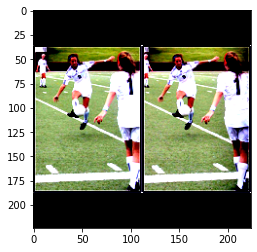

Correct:  <sos> các nữ cầu_thủ còn lại đang theo_dõi cú sút bóng của nữ cầu_thủ số chín <eos>
Predict:  <sos> hai vận_động_viên tennis đang thi_đấu ở trên sân <eos>
Bleu Score:  0.2380843705743307
---------------------------------------


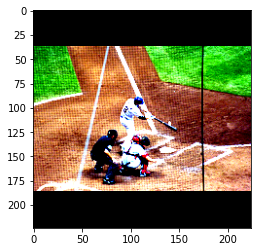

Correct:  <sos> cầu_thủ bắt bóng và trọng_tài đang theo_dõi động_tác của cầu_thủ đánh_bóng <eos>
Predict:  <sos> người đàn_ông đang chơi bóng_chày trên sân <eos>
Bleu Score:  0.2407236274713425
---------------------------------------


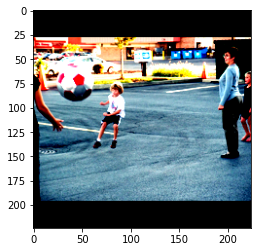

Correct:  <sos> huấn_luyện_viên đang theo_dõi buổi tập_luyện bóng_đá của học_trò <eos>
Predict:  <sos> một người đàn_ông đang chơi tennis ở trên sân <eos>
Bleu Score:  0.24870163223885466
---------------------------------------


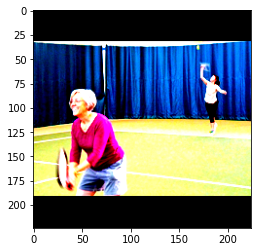

Correct:  <sos> người phụ_nữ áo xám đang chuẩn_bị phát_bóng trong khi người phụ_nữ áo tím đang đứng ở trên sân tennis <eos>
Predict:  <sos> một người đàn_ông đang chơi tennis trên sân <eos>
Bleu Score:  0.2507956760627278
---------------------------------------


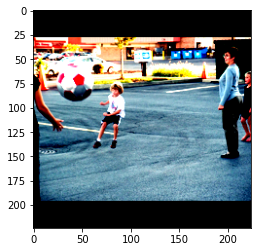

Correct:  <sos> phụ_huynh đang theo_dõi buổi tập_luyện bóng_đá của con mình <eos>
Predict:  <sos> một người đàn_ông đang chơi tennis ở trên sân <eos>
Bleu Score:  0.2580718413790311
---------------------------------------


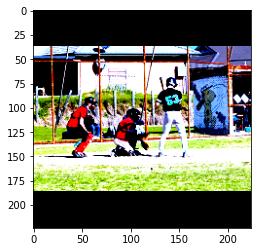

Correct:  <sos> trọng_tài đang theo_dõi động_tác của cầu_thủ bắt bóng và cầu_thủ đánh_bóng <eos>
Predict:  <sos> một người đàn_ông đang chơi bóng_chày ở trên sân <eos>
Bleu Score:  0.26097271391119753
---------------------------------------


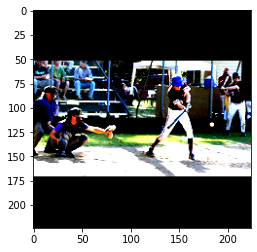

Correct:  <sos> cầu_thủ bắt bóng và trọng_tài đang theo_dõi động_tác của cầu_thủ đánh_bóng <eos>
Predict:  <sos> một người đàn_ông đang chơi bóng_chày ở trên sân <eos>
Bleu Score:  0.26097271391119753
---------------------------------------


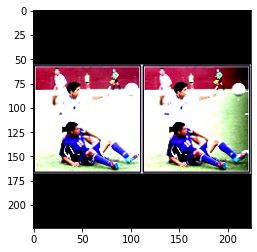

Correct:  <sos> cầu_thủ áo xanh đang ngồi tựa lưng vào chân của cầu_thủ áo trắng <eos>
Predict:  <sos> một người đàn_ông đang chơi bóng_chày ở trên sân <eos>
Bleu Score:  0.2719121022233622
---------------------------------------


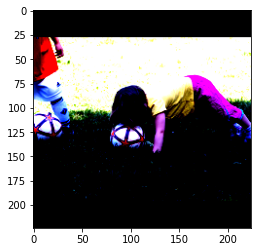

Correct:  <sos> một cậu bé đang hít đất cùng quả bóng và một cậu bé đang quan <eos>
Predict:  <sos> hai đứa trẻ đang chơi bóng_chày ở trên sân <eos>
Bleu Score:  0.27299538978184845
---------------------------------------


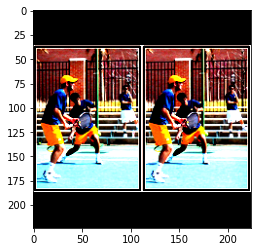

Correct:  <sos> một nam vận_động_viên tennis đang vung vợt để đánh_bóng trong khi người còn lại đang thủ_thế <eos>
Predict:  <sos> một người đàn_ông đang chơi tennis ở trên sân <eos>
Bleu Score:  0.28162539312512824


In [ ]:
#print top 10 worst bleu score results
df_ascending = df.sort_values(by=['Bleu Score'], ignore_index = True)
for i in range(10):
    print('---------------------------------------')
    img = df_ascending['Image'][i]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Correct: ', df_ascending['Correct'][i] )
    print('Predict: ', df_ascending['Predict'][i] )
    print('Bleu Score: ', df_ascending['Bleu Score'][i] )



We also look and our examples that show best predict preformance

In [ ]:
df = df.sort_values(by=['Bleu Score'], ascending=False)
df.head()

Index                                              Image  \
10      10  [[[tensor(-1.1035), tensor(-1.1035), tensor(-1...   
32      32  [[[tensor(-0.9174), tensor(-0.9174), tensor(-0...   
78      78  [[[tensor(-1.0862), tensor(-1.0862), tensor(-1...   
127    127  [[[tensor(-1.2370), tensor(-1.2370), tensor(-1...   
15      15  [[[tensor(-1.0243), tensor(-1.0243), tensor(-1...   

                                               Correct  \
10   <sos> vận_động_viên tennis đang cầm vợt thi_đấ...   
32   <sos> một người phụ_nữ đang chơi tennis ở trên...   
78   <sos> một_số người đàn_ông đang chơi bóng_chày...   
127  <sos> những người đàn_ông đang chơi bóng_chày ...   
15   <sos> một người đàn_ông đang chơi tennis ở trê...   

                                               Predict  Bleu Score  
10   <sos> vận_động_viên tennis đang cầm vợt thi_đấ...    1.000000  
32   <sos> hai người phụ_nữ đang chơi tennis ở trên...    0.916706  
78   <sos> một người đàn_ông đang chơi bóng_chày tr...    0.901353  
127  <sos> một người đàn_ông đang chơi bóng_chày ở ...    0.892212  
15   <sos> hai người đàn_ông đang chơi tennis trên ...    0.868120

# Visualizing the attentions

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        #encoder_out = model.encoder(features_tensors)
        #print(encoder_out)
        #encoder_out = torch.squeeze(encoder_out)
        beam_size = 5
        caption_length = 20
        #alphas = model.decoder.getAlpha(encoder_out,caption_length)
        caption_idx, alphas = model.predict(features_tensors,beam_size)
        caption_predict = []
        for i in caption_idx:
            caption_predict.append(idx_to_word[i])
        show_image(features_tensors.cpu(),title=caption)
    
    return caption_predict,alphas

In [ ]:
#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(30, 30))
    len_result = len(result)
    
    for l in range(len_result):
        a = (attention_plot[l].shape)
        x = a[0] * a[1]
        temp_att = attention_plot[l].reshape(28,int(x/28))
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.4, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


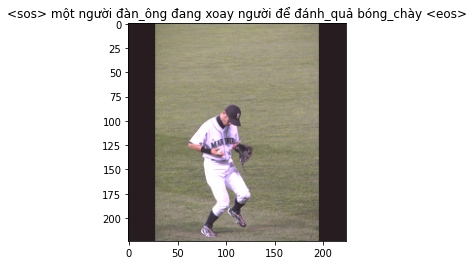

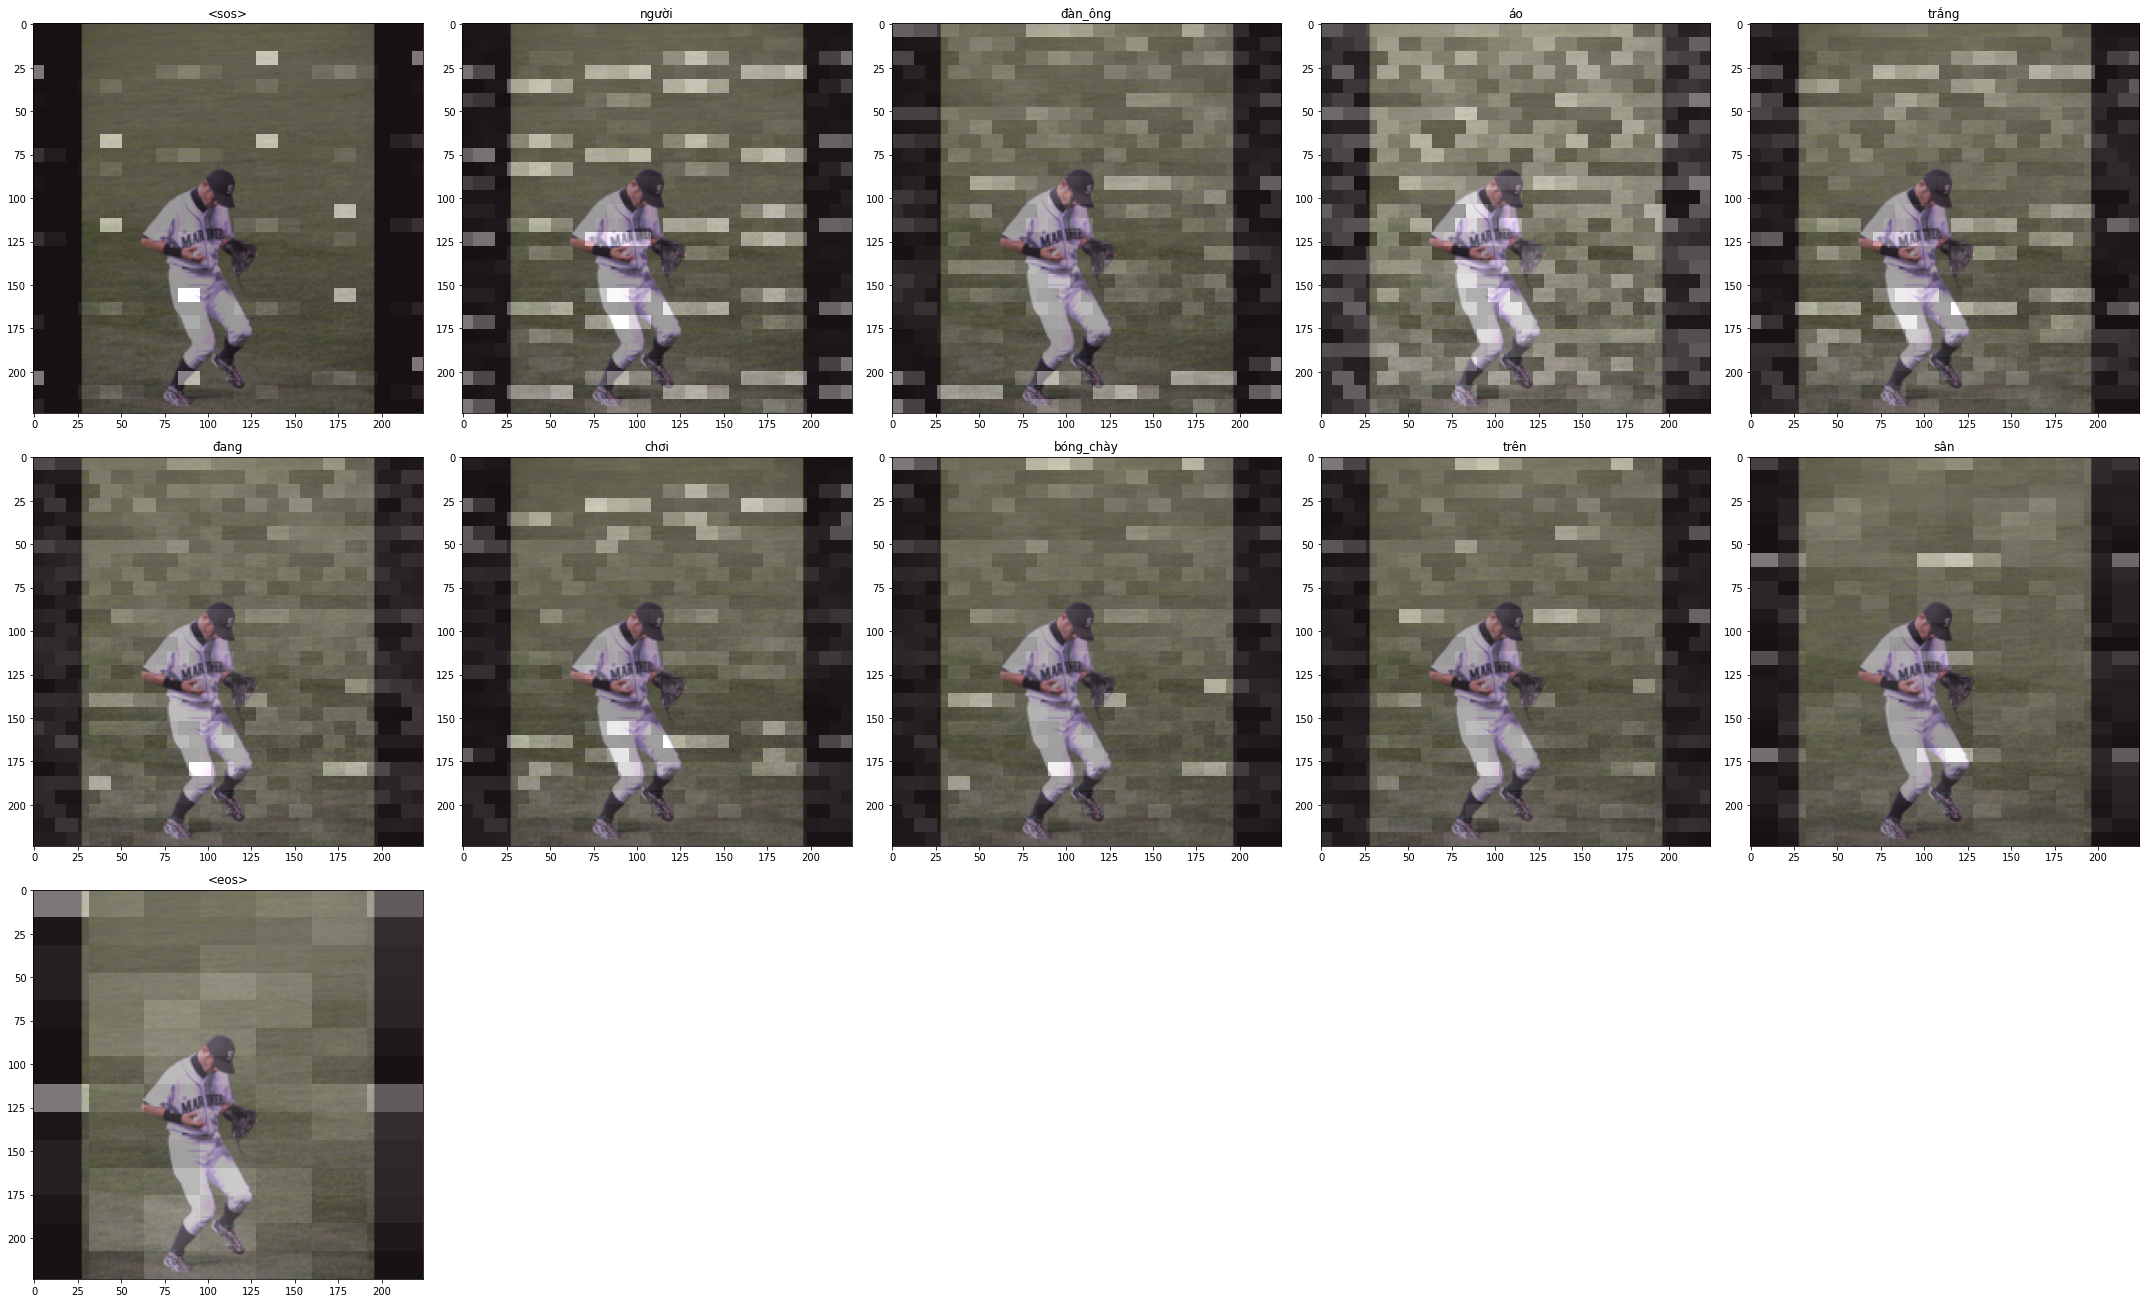

In [ ]:
#show any 1

img = train_image[6].detach().clone()
img1 = train_image[6].detach().clone()

caps,alphas = get_caps_from(img.to(device))

plot_attention(img1, caps, alphas)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


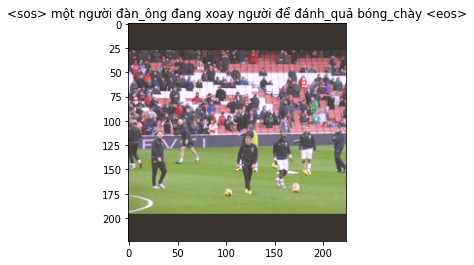

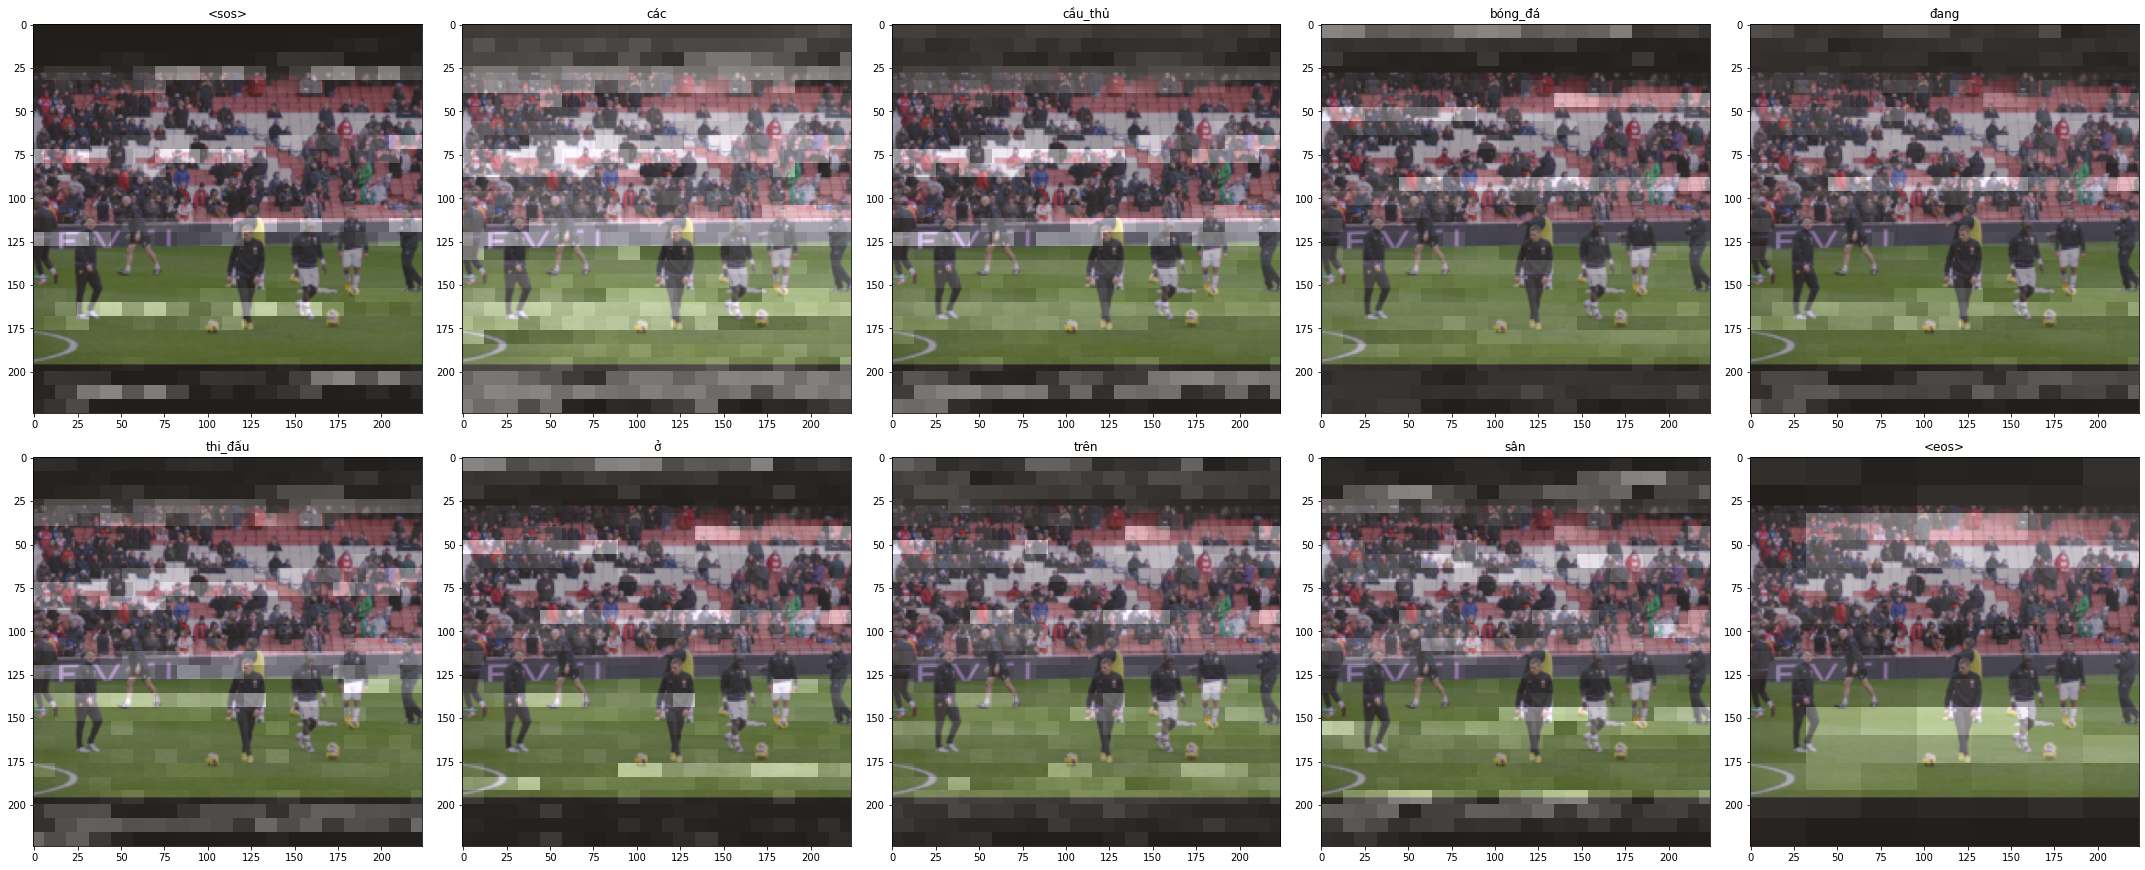

In [ ]:
#show any 1

img = test_image[19].detach().clone()
img1 = test_image[19].detach().clone()

caps,alphas = get_caps_from(img.to(device))

plot_attention(img1, caps, alphas)